In [1]:
from sklearn.cluster import KMeans
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.color import rgb2lab
import matplotlib.pyplot as plt


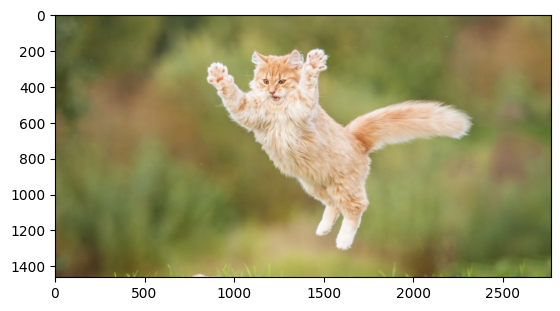

In [2]:
image = cv2.imread('cat.png')
plt.imshow(image[:,:,::-1])


In [3]:
def featurize(im,use_coord = True, normalize = True, add_grad_and_phase = False):
    H, W = im.shape[:2]
    y, x = np.mgrid[:H, :W]
    if use_coord:
        feat = np.concatenate((y[..., np.newaxis], x[..., np.newaxis], im), 2).astype('float')
    else:
        feat = im
        
    
    # apply gaussian blur
    im = cv2.GaussianBlur(im, (5, 5), 0)
    
    # add laplacian
    lapl = cv2.Laplacian(im, cv2.CV_64F)
    feat = np.concatenate((feat, lapl), 2)

    if add_grad_and_phase:
        #add x and y gradients
        grad_x = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=3)
        feat = np.concatenate((feat, grad_x), 2)
        feat = np.concatenate((feat, grad_y), 2)    
        #add phase
        phase = np.arctan2(grad_y, grad_x)
        feat = np.concatenate((feat, phase), 2)
    
    image_n =  feat.reshape(feat.shape[0]*feat.shape[1], feat.shape[2]).astype('float')
    if normalize:
        for i in range(image_n.shape[1]):
            image_n[:,i] = (image_n[:,i] - image_n[:,i].min())/(image_n[:,i].max() - image_n[:,i].min())
    return image_n


def defeaturize(orig,im,use_coord = False):
    H, W, C = orig.shape
    if use_coord:
        return im.reshape(H, W, C+2).astype(np.uint8)[:,:,2:]
    else:
        return im.reshape(H, W, C).astype(np.uint8)


/Users/teodorosullazzo/opt/anaconda3/envs/pytorch_env_2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(253272, 6)


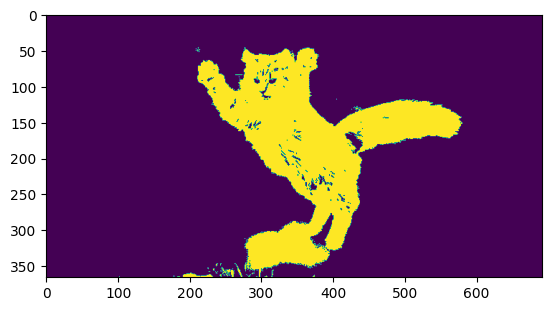

In [4]:
image = cv2.imread('cat.png')
image = cv2.resize(image, (0,0), fx=0.25, fy=0.25)

image_n = featurize(image,False,False)

image_n.shape
kmeans = KMeans(n_clusters=2, random_state=0).fit(image_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

print(pic2show.shape)
#cluster_pic = defeaturize(image,pic2show,False)
cluster_pic = kmeans.labels_.reshape(image.shape[0],image.shape[1])

plt.imshow(cluster_pic)


In [5]:
#image_n = featurize(image,True)#image_lab[:,:,:2],False)
image_lab = rgb2lab(image)
image_n = featurize(image_lab[:,:,:2],use_coord=False,normalize=False)



# Estimate bandwidth for meanshift algorithm    
bandwidth = estimate_bandwidth(image_n, quantile=0.1, n_samples=100)    
print("Estimated bandwidth : %d" % bandwidth)    


#ms = MeanShift(bandwidth = 10, bin_seeding=True)
ms = MeanShift(bandwidth = 10, bin_seeding=True)

# Performing meanshift on flatImg    
ms.fit(image_n)

Estimated bandwidth : 5


MeanShift(bandwidth=10, bin_seeding=True)

number of estimated clusters : 3


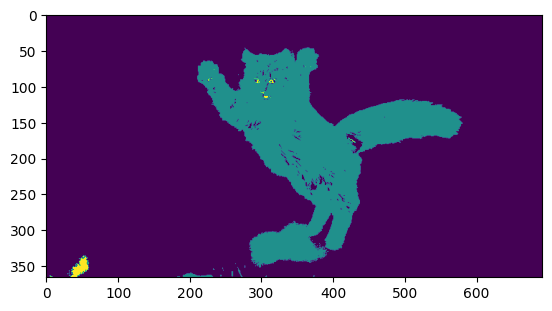

In [6]:
# (r,g,b) vectors corresponding to the different clusters after meanshift    
labels=ms.labels_

# Remaining colors after meanshift    
cluster_centers = ms.cluster_centers_    

# Finding and diplaying the number of clusters    
labels_unique = np.unique(labels)    
n_clusters_ = len(labels_unique)    
print("number of estimated clusters : %d" % n_clusters_)    

# Displaying segmented image    
segmentedImg = np.reshape(labels, image.shape[:2])  
plt.imshow(segmentedImg)